# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


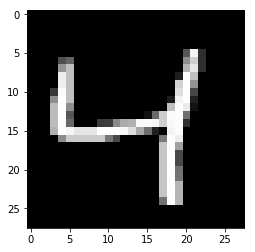

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [9]:
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
# Now 28x28x1

decoded = tf.nn.sigmoid(logits, name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

# Training
As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [10]:
sess = tf.Session()
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
  for ii in range(mnist.train.num_examples//batch_size):
    batch = mnist.train.next_batch(batch_size)
    imgs = batch[0].reshape((-1, 28, 28, 1))
    batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs, 
                                                     targets_: imgs})
    print('Epoch: {}/{}...'.format(e+1, epochs),
         'Training loss: {:.4f}'.format(batch_cost))

Epoch: 1/20... Training loss: 0.6932
Epoch: 1/20... Training loss: 0.6899
Epoch: 1/20... Training loss: 0.6865
Epoch: 1/20... Training loss: 0.6830
Epoch: 1/20... Training loss: 0.6783
Epoch: 1/20... Training loss: 0.6720
Epoch: 1/20... Training loss: 0.6690
Epoch: 1/20... Training loss: 0.6571
Epoch: 1/20... Training loss: 0.6460
Epoch: 1/20... Training loss: 0.6375
Epoch: 1/20... Training loss: 0.6242
Epoch: 1/20... Training loss: 0.6046
Epoch: 1/20... Training loss: 0.5882
Epoch: 1/20... Training loss: 0.5674
Epoch: 1/20... Training loss: 0.5494
Epoch: 1/20... Training loss: 0.5239
Epoch: 1/20... Training loss: 0.5200
Epoch: 1/20... Training loss: 0.5148
Epoch: 1/20... Training loss: 0.5504
Epoch: 1/20... Training loss: 0.5249
Epoch: 1/20... Training loss: 0.5235
Epoch: 1/20... Training loss: 0.5111
Epoch: 1/20... Training loss: 0.5090
Epoch: 1/20... Training loss: 0.5199
Epoch: 1/20... Training loss: 0.4904
Epoch: 1/20... Training loss: 0.4907
Epoch: 1/20... Training loss: 0.4924
E

Epoch: 1/20... Training loss: 0.1788
Epoch: 1/20... Training loss: 0.1767
Epoch: 1/20... Training loss: 0.1758
Epoch: 1/20... Training loss: 0.1760
Epoch: 1/20... Training loss: 0.1848
Epoch: 1/20... Training loss: 0.1760
Epoch: 1/20... Training loss: 0.1782
Epoch: 1/20... Training loss: 0.1759
Epoch: 1/20... Training loss: 0.1734
Epoch: 1/20... Training loss: 0.1754
Epoch: 1/20... Training loss: 0.1764
Epoch: 1/20... Training loss: 0.1819
Epoch: 1/20... Training loss: 0.1782
Epoch: 1/20... Training loss: 0.1727
Epoch: 1/20... Training loss: 0.1671
Epoch: 1/20... Training loss: 0.1787
Epoch: 1/20... Training loss: 0.1803
Epoch: 1/20... Training loss: 0.1728
Epoch: 1/20... Training loss: 0.1758
Epoch: 1/20... Training loss: 0.1778
Epoch: 1/20... Training loss: 0.1770
Epoch: 1/20... Training loss: 0.1794
Epoch: 1/20... Training loss: 0.1674
Epoch: 1/20... Training loss: 0.1774
Epoch: 1/20... Training loss: 0.1751
Epoch: 1/20... Training loss: 0.1763
Epoch: 1/20... Training loss: 0.1767
E

Epoch: 2/20... Training loss: 0.1466
Epoch: 2/20... Training loss: 0.1413
Epoch: 2/20... Training loss: 0.1470
Epoch: 2/20... Training loss: 0.1456
Epoch: 2/20... Training loss: 0.1416
Epoch: 2/20... Training loss: 0.1464
Epoch: 2/20... Training loss: 0.1405
Epoch: 2/20... Training loss: 0.1413
Epoch: 2/20... Training loss: 0.1449
Epoch: 2/20... Training loss: 0.1431
Epoch: 2/20... Training loss: 0.1388
Epoch: 2/20... Training loss: 0.1415
Epoch: 2/20... Training loss: 0.1416
Epoch: 2/20... Training loss: 0.1373
Epoch: 2/20... Training loss: 0.1380
Epoch: 2/20... Training loss: 0.1411
Epoch: 2/20... Training loss: 0.1369
Epoch: 2/20... Training loss: 0.1411
Epoch: 2/20... Training loss: 0.1447
Epoch: 2/20... Training loss: 0.1427
Epoch: 2/20... Training loss: 0.1354
Epoch: 2/20... Training loss: 0.1457
Epoch: 2/20... Training loss: 0.1403
Epoch: 2/20... Training loss: 0.1418
Epoch: 2/20... Training loss: 0.1378
Epoch: 2/20... Training loss: 0.1422
Epoch: 2/20... Training loss: 0.1365
E

Epoch: 3/20... Training loss: 0.1315
Epoch: 3/20... Training loss: 0.1311
Epoch: 3/20... Training loss: 0.1278
Epoch: 3/20... Training loss: 0.1322
Epoch: 3/20... Training loss: 0.1288
Epoch: 3/20... Training loss: 0.1310
Epoch: 3/20... Training loss: 0.1346
Epoch: 3/20... Training loss: 0.1314
Epoch: 3/20... Training loss: 0.1339
Epoch: 3/20... Training loss: 0.1310
Epoch: 3/20... Training loss: 0.1320
Epoch: 3/20... Training loss: 0.1292
Epoch: 3/20... Training loss: 0.1323
Epoch: 3/20... Training loss: 0.1308
Epoch: 3/20... Training loss: 0.1279
Epoch: 3/20... Training loss: 0.1263
Epoch: 3/20... Training loss: 0.1291
Epoch: 3/20... Training loss: 0.1263
Epoch: 3/20... Training loss: 0.1292
Epoch: 3/20... Training loss: 0.1301
Epoch: 3/20... Training loss: 0.1331
Epoch: 3/20... Training loss: 0.1287
Epoch: 3/20... Training loss: 0.1299
Epoch: 3/20... Training loss: 0.1374
Epoch: 3/20... Training loss: 0.1273
Epoch: 3/20... Training loss: 0.1244
Epoch: 3/20... Training loss: 0.1339
E

Epoch: 3/20... Training loss: 0.1242
Epoch: 3/20... Training loss: 0.1199
Epoch: 3/20... Training loss: 0.1202
Epoch: 3/20... Training loss: 0.1214
Epoch: 3/20... Training loss: 0.1241
Epoch: 3/20... Training loss: 0.1207
Epoch: 3/20... Training loss: 0.1183
Epoch: 3/20... Training loss: 0.1225
Epoch: 3/20... Training loss: 0.1240
Epoch: 3/20... Training loss: 0.1234
Epoch: 3/20... Training loss: 0.1202
Epoch: 3/20... Training loss: 0.1225
Epoch: 4/20... Training loss: 0.1273
Epoch: 4/20... Training loss: 0.1228
Epoch: 4/20... Training loss: 0.1184
Epoch: 4/20... Training loss: 0.1223
Epoch: 4/20... Training loss: 0.1265
Epoch: 4/20... Training loss: 0.1162
Epoch: 4/20... Training loss: 0.1254
Epoch: 4/20... Training loss: 0.1203
Epoch: 4/20... Training loss: 0.1214
Epoch: 4/20... Training loss: 0.1230
Epoch: 4/20... Training loss: 0.1210
Epoch: 4/20... Training loss: 0.1243
Epoch: 4/20... Training loss: 0.1178
Epoch: 4/20... Training loss: 0.1229
Epoch: 4/20... Training loss: 0.1187
E

Epoch: 4/20... Training loss: 0.1193
Epoch: 4/20... Training loss: 0.1158
Epoch: 4/20... Training loss: 0.1166
Epoch: 4/20... Training loss: 0.1178
Epoch: 4/20... Training loss: 0.1130
Epoch: 4/20... Training loss: 0.1151
Epoch: 4/20... Training loss: 0.1169
Epoch: 4/20... Training loss: 0.1205
Epoch: 4/20... Training loss: 0.1144
Epoch: 4/20... Training loss: 0.1185
Epoch: 4/20... Training loss: 0.1132
Epoch: 4/20... Training loss: 0.1178
Epoch: 4/20... Training loss: 0.1172
Epoch: 4/20... Training loss: 0.1176
Epoch: 4/20... Training loss: 0.1152
Epoch: 4/20... Training loss: 0.1165
Epoch: 4/20... Training loss: 0.1132
Epoch: 4/20... Training loss: 0.1177
Epoch: 4/20... Training loss: 0.1164
Epoch: 4/20... Training loss: 0.1111
Epoch: 4/20... Training loss: 0.1203
Epoch: 4/20... Training loss: 0.1177
Epoch: 4/20... Training loss: 0.1209
Epoch: 4/20... Training loss: 0.1164
Epoch: 4/20... Training loss: 0.1149
Epoch: 4/20... Training loss: 0.1124
Epoch: 4/20... Training loss: 0.1202
E

Epoch: 5/20... Training loss: 0.1163
Epoch: 5/20... Training loss: 0.1133
Epoch: 5/20... Training loss: 0.1137
Epoch: 5/20... Training loss: 0.1148
Epoch: 5/20... Training loss: 0.1097
Epoch: 5/20... Training loss: 0.1136
Epoch: 5/20... Training loss: 0.1115
Epoch: 5/20... Training loss: 0.1137
Epoch: 5/20... Training loss: 0.1106
Epoch: 5/20... Training loss: 0.1146
Epoch: 5/20... Training loss: 0.1110
Epoch: 5/20... Training loss: 0.1142
Epoch: 5/20... Training loss: 0.1167
Epoch: 5/20... Training loss: 0.1146
Epoch: 5/20... Training loss: 0.1132
Epoch: 5/20... Training loss: 0.1132
Epoch: 5/20... Training loss: 0.1122
Epoch: 5/20... Training loss: 0.1127
Epoch: 5/20... Training loss: 0.1136
Epoch: 5/20... Training loss: 0.1143
Epoch: 5/20... Training loss: 0.1116
Epoch: 5/20... Training loss: 0.1087
Epoch: 5/20... Training loss: 0.1146
Epoch: 5/20... Training loss: 0.1138
Epoch: 5/20... Training loss: 0.1157
Epoch: 5/20... Training loss: 0.1145
Epoch: 5/20... Training loss: 0.1173
E

Epoch: 6/20... Training loss: 0.1081
Epoch: 6/20... Training loss: 0.1089
Epoch: 6/20... Training loss: 0.1143
Epoch: 6/20... Training loss: 0.1074
Epoch: 6/20... Training loss: 0.1103
Epoch: 6/20... Training loss: 0.1099
Epoch: 6/20... Training loss: 0.1138
Epoch: 6/20... Training loss: 0.1046
Epoch: 6/20... Training loss: 0.1142
Epoch: 6/20... Training loss: 0.1081
Epoch: 6/20... Training loss: 0.1143
Epoch: 6/20... Training loss: 0.1078
Epoch: 6/20... Training loss: 0.1063
Epoch: 6/20... Training loss: 0.1104
Epoch: 6/20... Training loss: 0.1117
Epoch: 6/20... Training loss: 0.1106
Epoch: 6/20... Training loss: 0.1077
Epoch: 6/20... Training loss: 0.1078
Epoch: 6/20... Training loss: 0.1122
Epoch: 6/20... Training loss: 0.1100
Epoch: 6/20... Training loss: 0.1091
Epoch: 6/20... Training loss: 0.1105
Epoch: 6/20... Training loss: 0.1095
Epoch: 6/20... Training loss: 0.1082
Epoch: 6/20... Training loss: 0.1115
Epoch: 6/20... Training loss: 0.1083
Epoch: 6/20... Training loss: 0.1064
E

Epoch: 6/20... Training loss: 0.1083
Epoch: 6/20... Training loss: 0.1064
Epoch: 6/20... Training loss: 0.1054
Epoch: 6/20... Training loss: 0.1084
Epoch: 6/20... Training loss: 0.1109
Epoch: 6/20... Training loss: 0.1091
Epoch: 6/20... Training loss: 0.1060
Epoch: 6/20... Training loss: 0.1093
Epoch: 6/20... Training loss: 0.1084
Epoch: 6/20... Training loss: 0.1088
Epoch: 6/20... Training loss: 0.1102
Epoch: 6/20... Training loss: 0.1050
Epoch: 6/20... Training loss: 0.1063
Epoch: 6/20... Training loss: 0.1074
Epoch: 6/20... Training loss: 0.1059
Epoch: 6/20... Training loss: 0.1117
Epoch: 6/20... Training loss: 0.1078
Epoch: 6/20... Training loss: 0.1056
Epoch: 6/20... Training loss: 0.1084
Epoch: 6/20... Training loss: 0.1034
Epoch: 6/20... Training loss: 0.1097
Epoch: 6/20... Training loss: 0.1095
Epoch: 6/20... Training loss: 0.1059
Epoch: 6/20... Training loss: 0.1022
Epoch: 7/20... Training loss: 0.1109
Epoch: 7/20... Training loss: 0.1056
Epoch: 7/20... Training loss: 0.1101
E

Epoch: 7/20... Training loss: 0.1050
Epoch: 7/20... Training loss: 0.1061
Epoch: 7/20... Training loss: 0.1031
Epoch: 7/20... Training loss: 0.1043
Epoch: 7/20... Training loss: 0.1067
Epoch: 7/20... Training loss: 0.1063
Epoch: 7/20... Training loss: 0.1072
Epoch: 7/20... Training loss: 0.1098
Epoch: 7/20... Training loss: 0.1015
Epoch: 7/20... Training loss: 0.1057
Epoch: 7/20... Training loss: 0.1011
Epoch: 7/20... Training loss: 0.1041
Epoch: 7/20... Training loss: 0.1070
Epoch: 7/20... Training loss: 0.1087
Epoch: 7/20... Training loss: 0.1055
Epoch: 7/20... Training loss: 0.1032
Epoch: 7/20... Training loss: 0.1048
Epoch: 7/20... Training loss: 0.1016
Epoch: 7/20... Training loss: 0.1027
Epoch: 7/20... Training loss: 0.1061
Epoch: 7/20... Training loss: 0.1063
Epoch: 7/20... Training loss: 0.1051
Epoch: 7/20... Training loss: 0.1068
Epoch: 7/20... Training loss: 0.1077
Epoch: 7/20... Training loss: 0.1046
Epoch: 7/20... Training loss: 0.1106
Epoch: 7/20... Training loss: 0.1041
E

Epoch: 8/20... Training loss: 0.1062
Epoch: 8/20... Training loss: 0.1019
Epoch: 8/20... Training loss: 0.1026
Epoch: 8/20... Training loss: 0.1060
Epoch: 8/20... Training loss: 0.1021
Epoch: 8/20... Training loss: 0.1049
Epoch: 8/20... Training loss: 0.1055
Epoch: 8/20... Training loss: 0.1074
Epoch: 8/20... Training loss: 0.1049
Epoch: 8/20... Training loss: 0.1005
Epoch: 8/20... Training loss: 0.1031
Epoch: 8/20... Training loss: 0.1041
Epoch: 8/20... Training loss: 0.1041
Epoch: 8/20... Training loss: 0.1023
Epoch: 8/20... Training loss: 0.1050
Epoch: 8/20... Training loss: 0.1035
Epoch: 8/20... Training loss: 0.1018
Epoch: 8/20... Training loss: 0.0997
Epoch: 8/20... Training loss: 0.1035
Epoch: 8/20... Training loss: 0.1019
Epoch: 8/20... Training loss: 0.1061
Epoch: 8/20... Training loss: 0.1053
Epoch: 8/20... Training loss: 0.1067
Epoch: 8/20... Training loss: 0.1033
Epoch: 8/20... Training loss: 0.1019
Epoch: 8/20... Training loss: 0.1020
Epoch: 8/20... Training loss: 0.1041
E

Epoch: 9/20... Training loss: 0.0982
Epoch: 9/20... Training loss: 0.1008
Epoch: 9/20... Training loss: 0.1024
Epoch: 9/20... Training loss: 0.1094
Epoch: 9/20... Training loss: 0.1017
Epoch: 9/20... Training loss: 0.1019
Epoch: 9/20... Training loss: 0.1008
Epoch: 9/20... Training loss: 0.1025
Epoch: 9/20... Training loss: 0.1014
Epoch: 9/20... Training loss: 0.1005
Epoch: 9/20... Training loss: 0.1031
Epoch: 9/20... Training loss: 0.1010
Epoch: 9/20... Training loss: 0.1033
Epoch: 9/20... Training loss: 0.0987
Epoch: 9/20... Training loss: 0.1034
Epoch: 9/20... Training loss: 0.1023
Epoch: 9/20... Training loss: 0.1081
Epoch: 9/20... Training loss: 0.1011
Epoch: 9/20... Training loss: 0.1018
Epoch: 9/20... Training loss: 0.1008
Epoch: 9/20... Training loss: 0.1014
Epoch: 9/20... Training loss: 0.1023
Epoch: 9/20... Training loss: 0.1017
Epoch: 9/20... Training loss: 0.1002
Epoch: 9/20... Training loss: 0.1034
Epoch: 9/20... Training loss: 0.1010
Epoch: 9/20... Training loss: 0.1015
E

Epoch: 9/20... Training loss: 0.1011
Epoch: 9/20... Training loss: 0.1008
Epoch: 9/20... Training loss: 0.1028
Epoch: 9/20... Training loss: 0.0990
Epoch: 9/20... Training loss: 0.1035
Epoch: 9/20... Training loss: 0.1024
Epoch: 9/20... Training loss: 0.1005
Epoch: 9/20... Training loss: 0.1024
Epoch: 9/20... Training loss: 0.0999
Epoch: 9/20... Training loss: 0.1043
Epoch: 9/20... Training loss: 0.1008
Epoch: 9/20... Training loss: 0.1024
Epoch: 9/20... Training loss: 0.1026
Epoch: 9/20... Training loss: 0.1017
Epoch: 9/20... Training loss: 0.0992
Epoch: 9/20... Training loss: 0.1006
Epoch: 9/20... Training loss: 0.1041
Epoch: 9/20... Training loss: 0.0993
Epoch: 9/20... Training loss: 0.0991
Epoch: 9/20... Training loss: 0.1011
Epoch: 9/20... Training loss: 0.1005
Epoch: 9/20... Training loss: 0.1042
Epoch: 9/20... Training loss: 0.1032
Epoch: 9/20... Training loss: 0.1027
Epoch: 9/20... Training loss: 0.1039
Epoch: 9/20... Training loss: 0.1009
Epoch: 9/20... Training loss: 0.0989
E

Epoch: 10/20... Training loss: 0.0990
Epoch: 10/20... Training loss: 0.1001
Epoch: 10/20... Training loss: 0.1038
Epoch: 10/20... Training loss: 0.1027
Epoch: 10/20... Training loss: 0.1044
Epoch: 10/20... Training loss: 0.0968
Epoch: 10/20... Training loss: 0.1030
Epoch: 10/20... Training loss: 0.1000
Epoch: 10/20... Training loss: 0.1001
Epoch: 10/20... Training loss: 0.0990
Epoch: 10/20... Training loss: 0.1036
Epoch: 10/20... Training loss: 0.0967
Epoch: 10/20... Training loss: 0.1037
Epoch: 10/20... Training loss: 0.1008
Epoch: 10/20... Training loss: 0.1020
Epoch: 10/20... Training loss: 0.0986
Epoch: 10/20... Training loss: 0.1016
Epoch: 10/20... Training loss: 0.0994
Epoch: 10/20... Training loss: 0.1022
Epoch: 10/20... Training loss: 0.1006
Epoch: 10/20... Training loss: 0.1023
Epoch: 10/20... Training loss: 0.1014
Epoch: 10/20... Training loss: 0.1004
Epoch: 10/20... Training loss: 0.1046
Epoch: 10/20... Training loss: 0.0987
Epoch: 10/20... Training loss: 0.1021
Epoch: 10/20

Epoch: 11/20... Training loss: 0.1026
Epoch: 11/20... Training loss: 0.0987
Epoch: 11/20... Training loss: 0.1011
Epoch: 11/20... Training loss: 0.0998
Epoch: 11/20... Training loss: 0.1026
Epoch: 11/20... Training loss: 0.1033
Epoch: 11/20... Training loss: 0.0993
Epoch: 11/20... Training loss: 0.0975
Epoch: 11/20... Training loss: 0.0976
Epoch: 11/20... Training loss: 0.0974
Epoch: 11/20... Training loss: 0.1016
Epoch: 11/20... Training loss: 0.0979
Epoch: 11/20... Training loss: 0.0994
Epoch: 11/20... Training loss: 0.1033
Epoch: 11/20... Training loss: 0.0984
Epoch: 11/20... Training loss: 0.1001
Epoch: 11/20... Training loss: 0.0979
Epoch: 11/20... Training loss: 0.1017
Epoch: 11/20... Training loss: 0.1031
Epoch: 11/20... Training loss: 0.1003
Epoch: 11/20... Training loss: 0.0940
Epoch: 11/20... Training loss: 0.1016
Epoch: 11/20... Training loss: 0.0965
Epoch: 11/20... Training loss: 0.1018
Epoch: 11/20... Training loss: 0.0965
Epoch: 11/20... Training loss: 0.1004
Epoch: 11/20

Epoch: 12/20... Training loss: 0.1003
Epoch: 12/20... Training loss: 0.0997
Epoch: 12/20... Training loss: 0.0988
Epoch: 12/20... Training loss: 0.0969
Epoch: 12/20... Training loss: 0.0958
Epoch: 12/20... Training loss: 0.0982
Epoch: 12/20... Training loss: 0.1002
Epoch: 12/20... Training loss: 0.0988
Epoch: 12/20... Training loss: 0.1018
Epoch: 12/20... Training loss: 0.1019
Epoch: 12/20... Training loss: 0.1018
Epoch: 12/20... Training loss: 0.1012
Epoch: 12/20... Training loss: 0.0980
Epoch: 12/20... Training loss: 0.0970
Epoch: 12/20... Training loss: 0.0996
Epoch: 12/20... Training loss: 0.1030
Epoch: 12/20... Training loss: 0.0973
Epoch: 12/20... Training loss: 0.1024
Epoch: 12/20... Training loss: 0.0992
Epoch: 12/20... Training loss: 0.0994
Epoch: 12/20... Training loss: 0.0980
Epoch: 12/20... Training loss: 0.1010
Epoch: 12/20... Training loss: 0.1004
Epoch: 12/20... Training loss: 0.1048
Epoch: 12/20... Training loss: 0.0994
Epoch: 12/20... Training loss: 0.1001
Epoch: 12/20

Epoch: 12/20... Training loss: 0.0955
Epoch: 12/20... Training loss: 0.0983
Epoch: 12/20... Training loss: 0.0995
Epoch: 12/20... Training loss: 0.1002
Epoch: 12/20... Training loss: 0.0989
Epoch: 12/20... Training loss: 0.0972
Epoch: 12/20... Training loss: 0.0984
Epoch: 12/20... Training loss: 0.1042
Epoch: 12/20... Training loss: 0.0999
Epoch: 12/20... Training loss: 0.0978
Epoch: 12/20... Training loss: 0.0964
Epoch: 12/20... Training loss: 0.0970
Epoch: 12/20... Training loss: 0.0968
Epoch: 12/20... Training loss: 0.1002
Epoch: 12/20... Training loss: 0.0964
Epoch: 12/20... Training loss: 0.0968
Epoch: 12/20... Training loss: 0.0992
Epoch: 12/20... Training loss: 0.0971
Epoch: 12/20... Training loss: 0.0950
Epoch: 12/20... Training loss: 0.0990
Epoch: 12/20... Training loss: 0.0981
Epoch: 12/20... Training loss: 0.1006
Epoch: 12/20... Training loss: 0.0986
Epoch: 12/20... Training loss: 0.1015
Epoch: 12/20... Training loss: 0.0954
Epoch: 12/20... Training loss: 0.0959
Epoch: 12/20

Epoch: 13/20... Training loss: 0.1002
Epoch: 13/20... Training loss: 0.0982
Epoch: 13/20... Training loss: 0.0995
Epoch: 13/20... Training loss: 0.0919
Epoch: 13/20... Training loss: 0.0981
Epoch: 13/20... Training loss: 0.0985
Epoch: 13/20... Training loss: 0.0985
Epoch: 13/20... Training loss: 0.0974
Epoch: 13/20... Training loss: 0.0978
Epoch: 13/20... Training loss: 0.1008
Epoch: 13/20... Training loss: 0.0983
Epoch: 13/20... Training loss: 0.0945
Epoch: 13/20... Training loss: 0.1000
Epoch: 13/20... Training loss: 0.1002
Epoch: 13/20... Training loss: 0.0962
Epoch: 13/20... Training loss: 0.1029
Epoch: 13/20... Training loss: 0.0946
Epoch: 13/20... Training loss: 0.0919
Epoch: 13/20... Training loss: 0.1010
Epoch: 13/20... Training loss: 0.0984
Epoch: 13/20... Training loss: 0.0982
Epoch: 13/20... Training loss: 0.1023
Epoch: 13/20... Training loss: 0.1022
Epoch: 13/20... Training loss: 0.0954
Epoch: 13/20... Training loss: 0.0990
Epoch: 13/20... Training loss: 0.0952
Epoch: 13/20

Epoch: 14/20... Training loss: 0.0969
Epoch: 14/20... Training loss: 0.0959
Epoch: 14/20... Training loss: 0.0978
Epoch: 14/20... Training loss: 0.0923
Epoch: 14/20... Training loss: 0.0969
Epoch: 14/20... Training loss: 0.0966
Epoch: 14/20... Training loss: 0.0955
Epoch: 14/20... Training loss: 0.0992
Epoch: 14/20... Training loss: 0.0956
Epoch: 14/20... Training loss: 0.0963
Epoch: 14/20... Training loss: 0.0976
Epoch: 14/20... Training loss: 0.0977
Epoch: 14/20... Training loss: 0.0968
Epoch: 14/20... Training loss: 0.0983
Epoch: 14/20... Training loss: 0.1027
Epoch: 14/20... Training loss: 0.0995
Epoch: 14/20... Training loss: 0.0951
Epoch: 14/20... Training loss: 0.0962
Epoch: 14/20... Training loss: 0.1002
Epoch: 14/20... Training loss: 0.0965
Epoch: 14/20... Training loss: 0.0990
Epoch: 14/20... Training loss: 0.0978
Epoch: 14/20... Training loss: 0.0957
Epoch: 14/20... Training loss: 0.0958
Epoch: 14/20... Training loss: 0.0983
Epoch: 14/20... Training loss: 0.0993
Epoch: 14/20

Epoch: 14/20... Training loss: 0.0992
Epoch: 14/20... Training loss: 0.0987
Epoch: 14/20... Training loss: 0.0966
Epoch: 14/20... Training loss: 0.0979
Epoch: 14/20... Training loss: 0.0974
Epoch: 14/20... Training loss: 0.0982
Epoch: 14/20... Training loss: 0.0948
Epoch: 14/20... Training loss: 0.0981
Epoch: 14/20... Training loss: 0.0956
Epoch: 14/20... Training loss: 0.0998
Epoch: 14/20... Training loss: 0.0966
Epoch: 14/20... Training loss: 0.0978
Epoch: 14/20... Training loss: 0.0975
Epoch: 14/20... Training loss: 0.0967
Epoch: 14/20... Training loss: 0.0966
Epoch: 14/20... Training loss: 0.0953
Epoch: 14/20... Training loss: 0.0976
Epoch: 14/20... Training loss: 0.0985
Epoch: 14/20... Training loss: 0.0988
Epoch: 14/20... Training loss: 0.0958
Epoch: 14/20... Training loss: 0.0967
Epoch: 14/20... Training loss: 0.0985
Epoch: 14/20... Training loss: 0.0961
Epoch: 15/20... Training loss: 0.0994
Epoch: 15/20... Training loss: 0.0968
Epoch: 15/20... Training loss: 0.0976
Epoch: 15/20

Epoch: 15/20... Training loss: 0.0958
Epoch: 15/20... Training loss: 0.0951
Epoch: 15/20... Training loss: 0.0942
Epoch: 15/20... Training loss: 0.0946
Epoch: 15/20... Training loss: 0.0986
Epoch: 15/20... Training loss: 0.0964
Epoch: 15/20... Training loss: 0.1012
Epoch: 15/20... Training loss: 0.0975
Epoch: 15/20... Training loss: 0.0970
Epoch: 15/20... Training loss: 0.0971
Epoch: 15/20... Training loss: 0.0983
Epoch: 15/20... Training loss: 0.1015
Epoch: 15/20... Training loss: 0.0927
Epoch: 15/20... Training loss: 0.0954
Epoch: 15/20... Training loss: 0.1011
Epoch: 15/20... Training loss: 0.0961
Epoch: 15/20... Training loss: 0.0957
Epoch: 15/20... Training loss: 0.0942
Epoch: 15/20... Training loss: 0.0937
Epoch: 15/20... Training loss: 0.0968
Epoch: 15/20... Training loss: 0.0940
Epoch: 15/20... Training loss: 0.0966
Epoch: 15/20... Training loss: 0.1000
Epoch: 15/20... Training loss: 0.0983
Epoch: 15/20... Training loss: 0.1017
Epoch: 15/20... Training loss: 0.0964
Epoch: 15/20

Epoch: 16/20... Training loss: 0.0949
Epoch: 16/20... Training loss: 0.0956
Epoch: 16/20... Training loss: 0.0936
Epoch: 16/20... Training loss: 0.0950
Epoch: 16/20... Training loss: 0.0951
Epoch: 16/20... Training loss: 0.0967
Epoch: 16/20... Training loss: 0.0971
Epoch: 16/20... Training loss: 0.0956
Epoch: 16/20... Training loss: 0.0959
Epoch: 16/20... Training loss: 0.0987
Epoch: 16/20... Training loss: 0.0924
Epoch: 16/20... Training loss: 0.0949
Epoch: 16/20... Training loss: 0.0952
Epoch: 16/20... Training loss: 0.0994
Epoch: 16/20... Training loss: 0.1010
Epoch: 16/20... Training loss: 0.0988
Epoch: 16/20... Training loss: 0.0954
Epoch: 16/20... Training loss: 0.0977
Epoch: 16/20... Training loss: 0.0977
Epoch: 16/20... Training loss: 0.0951
Epoch: 16/20... Training loss: 0.0951
Epoch: 16/20... Training loss: 0.0940
Epoch: 16/20... Training loss: 0.0968
Epoch: 16/20... Training loss: 0.0978
Epoch: 16/20... Training loss: 0.0966
Epoch: 16/20... Training loss: 0.0930
Epoch: 16/20

Epoch: 17/20... Training loss: 0.0952
Epoch: 17/20... Training loss: 0.1002
Epoch: 17/20... Training loss: 0.0962
Epoch: 17/20... Training loss: 0.0967
Epoch: 17/20... Training loss: 0.0970
Epoch: 17/20... Training loss: 0.0991
Epoch: 17/20... Training loss: 0.0948
Epoch: 17/20... Training loss: 0.0959
Epoch: 17/20... Training loss: 0.0939
Epoch: 17/20... Training loss: 0.0986
Epoch: 17/20... Training loss: 0.0935
Epoch: 17/20... Training loss: 0.0933
Epoch: 17/20... Training loss: 0.0935
Epoch: 17/20... Training loss: 0.0989
Epoch: 17/20... Training loss: 0.0981
Epoch: 17/20... Training loss: 0.0955
Epoch: 17/20... Training loss: 0.0970
Epoch: 17/20... Training loss: 0.0938
Epoch: 17/20... Training loss: 0.0976
Epoch: 17/20... Training loss: 0.0963
Epoch: 17/20... Training loss: 0.0939
Epoch: 17/20... Training loss: 0.0961
Epoch: 17/20... Training loss: 0.0982
Epoch: 17/20... Training loss: 0.0922
Epoch: 17/20... Training loss: 0.0985
Epoch: 17/20... Training loss: 0.0938
Epoch: 17/20

Epoch: 17/20... Training loss: 0.0954
Epoch: 17/20... Training loss: 0.0921
Epoch: 17/20... Training loss: 0.0953
Epoch: 17/20... Training loss: 0.0948
Epoch: 17/20... Training loss: 0.0957
Epoch: 17/20... Training loss: 0.0983
Epoch: 17/20... Training loss: 0.0997
Epoch: 17/20... Training loss: 0.0920
Epoch: 17/20... Training loss: 0.0978
Epoch: 17/20... Training loss: 0.0922
Epoch: 17/20... Training loss: 0.0951
Epoch: 17/20... Training loss: 0.0910
Epoch: 17/20... Training loss: 0.0938
Epoch: 17/20... Training loss: 0.0960
Epoch: 17/20... Training loss: 0.0968
Epoch: 17/20... Training loss: 0.0961
Epoch: 17/20... Training loss: 0.0971
Epoch: 17/20... Training loss: 0.0987
Epoch: 17/20... Training loss: 0.0992
Epoch: 17/20... Training loss: 0.0973
Epoch: 17/20... Training loss: 0.0969
Epoch: 17/20... Training loss: 0.0905
Epoch: 17/20... Training loss: 0.0969
Epoch: 17/20... Training loss: 0.0952
Epoch: 17/20... Training loss: 0.0965
Epoch: 17/20... Training loss: 0.0973
Epoch: 17/20

Epoch: 18/20... Training loss: 0.0959
Epoch: 18/20... Training loss: 0.0982
Epoch: 18/20... Training loss: 0.0977
Epoch: 18/20... Training loss: 0.0940
Epoch: 18/20... Training loss: 0.0938
Epoch: 18/20... Training loss: 0.0935
Epoch: 18/20... Training loss: 0.0944
Epoch: 18/20... Training loss: 0.0930
Epoch: 18/20... Training loss: 0.0944
Epoch: 18/20... Training loss: 0.0930
Epoch: 18/20... Training loss: 0.0951
Epoch: 18/20... Training loss: 0.0941
Epoch: 18/20... Training loss: 0.0967
Epoch: 18/20... Training loss: 0.0989
Epoch: 18/20... Training loss: 0.0979
Epoch: 18/20... Training loss: 0.0945
Epoch: 18/20... Training loss: 0.0970
Epoch: 18/20... Training loss: 0.0921
Epoch: 18/20... Training loss: 0.0933
Epoch: 18/20... Training loss: 0.0946
Epoch: 18/20... Training loss: 0.0962
Epoch: 18/20... Training loss: 0.0949
Epoch: 18/20... Training loss: 0.0948
Epoch: 18/20... Training loss: 0.0962
Epoch: 18/20... Training loss: 0.0946
Epoch: 18/20... Training loss: 0.0949
Epoch: 18/20

Epoch: 19/20... Training loss: 0.0963
Epoch: 19/20... Training loss: 0.0939
Epoch: 19/20... Training loss: 0.0933
Epoch: 19/20... Training loss: 0.0964
Epoch: 19/20... Training loss: 0.0940
Epoch: 19/20... Training loss: 0.0948
Epoch: 19/20... Training loss: 0.0925
Epoch: 19/20... Training loss: 0.0938
Epoch: 19/20... Training loss: 0.0939
Epoch: 19/20... Training loss: 0.0933
Epoch: 19/20... Training loss: 0.0965
Epoch: 19/20... Training loss: 0.0967
Epoch: 19/20... Training loss: 0.0942
Epoch: 19/20... Training loss: 0.0933
Epoch: 19/20... Training loss: 0.0933
Epoch: 19/20... Training loss: 0.0917
Epoch: 19/20... Training loss: 0.0940
Epoch: 19/20... Training loss: 0.0948
Epoch: 19/20... Training loss: 0.0930
Epoch: 19/20... Training loss: 0.0944
Epoch: 19/20... Training loss: 0.0967
Epoch: 19/20... Training loss: 0.0912
Epoch: 19/20... Training loss: 0.0966
Epoch: 19/20... Training loss: 0.0923
Epoch: 19/20... Training loss: 0.0940
Epoch: 19/20... Training loss: 0.0912
Epoch: 19/20

Epoch: 19/20... Training loss: 0.0976
Epoch: 19/20... Training loss: 0.0996
Epoch: 19/20... Training loss: 0.0915
Epoch: 19/20... Training loss: 0.0957
Epoch: 19/20... Training loss: 0.0946
Epoch: 19/20... Training loss: 0.0974
Epoch: 19/20... Training loss: 0.0934
Epoch: 19/20... Training loss: 0.0903
Epoch: 19/20... Training loss: 0.0976
Epoch: 19/20... Training loss: 0.0967
Epoch: 19/20... Training loss: 0.0917
Epoch: 20/20... Training loss: 0.0948
Epoch: 20/20... Training loss: 0.0897
Epoch: 20/20... Training loss: 0.0930
Epoch: 20/20... Training loss: 0.0958
Epoch: 20/20... Training loss: 0.0977
Epoch: 20/20... Training loss: 0.0927
Epoch: 20/20... Training loss: 0.0951
Epoch: 20/20... Training loss: 0.0953
Epoch: 20/20... Training loss: 0.0947
Epoch: 20/20... Training loss: 0.0927
Epoch: 20/20... Training loss: 0.0948
Epoch: 20/20... Training loss: 0.0955
Epoch: 20/20... Training loss: 0.0936
Epoch: 20/20... Training loss: 0.0993
Epoch: 20/20... Training loss: 0.0934
Epoch: 20/20

Epoch: 20/20... Training loss: 0.0943
Epoch: 20/20... Training loss: 0.0924
Epoch: 20/20... Training loss: 0.0955
Epoch: 20/20... Training loss: 0.0941
Epoch: 20/20... Training loss: 0.0962
Epoch: 20/20... Training loss: 0.0965
Epoch: 20/20... Training loss: 0.0935
Epoch: 20/20... Training loss: 0.0969
Epoch: 20/20... Training loss: 0.0926
Epoch: 20/20... Training loss: 0.0929
Epoch: 20/20... Training loss: 0.0950
Epoch: 20/20... Training loss: 0.0944
Epoch: 20/20... Training loss: 0.0942
Epoch: 20/20... Training loss: 0.0966
Epoch: 20/20... Training loss: 0.0969
Epoch: 20/20... Training loss: 0.0956
Epoch: 20/20... Training loss: 0.0915
Epoch: 20/20... Training loss: 0.0921
Epoch: 20/20... Training loss: 0.0922
Epoch: 20/20... Training loss: 0.0963
Epoch: 20/20... Training loss: 0.0879
Epoch: 20/20... Training loss: 0.0970
Epoch: 20/20... Training loss: 0.0925
Epoch: 20/20... Training loss: 0.0967
Epoch: 20/20... Training loss: 0.0945
Epoch: 20/20... Training loss: 0.0937
Epoch: 20/20

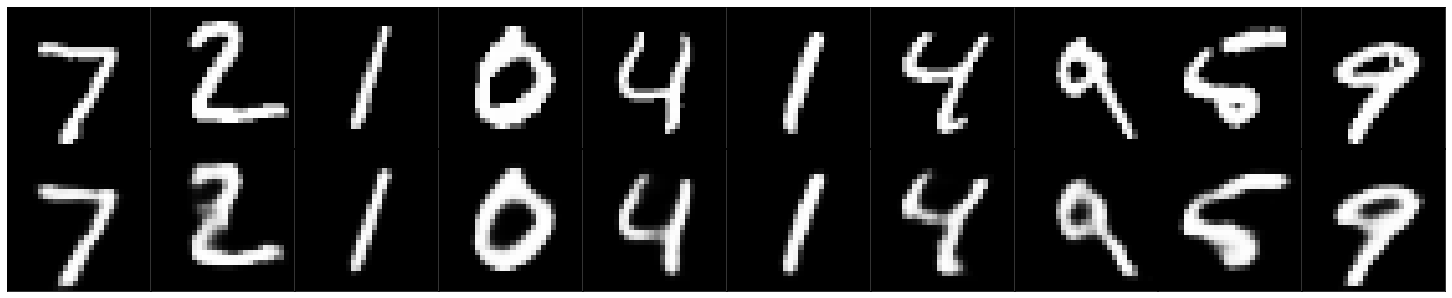

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in  zip([in_imgs, reconstructed], axes):
  for img, ax in zip(images, row):
    ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [14]:
in_imgs[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [6]:
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32
decoded = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
# Now 28x28x1

logits = tf.nn.sigmoid(decoded)
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

In [7]:
sess = tf.Session()

In [8]:
epochs = 10
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
  for ii in range(mnist.train.num_examples//batch_size):
    batch = mnist.train.next_batch(batch_size)
    
    # Get images from the batch
    imgs = batch[0].reshape((-1, 28, 28, 1))
    
    # Add random noise to the input images
    noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
    # Clip the images to be between 0 and 1
    noisy_imgs = np.clip(noisy_imgs, 0., 1.)
    
    # Noisy images as inputs, original images as targets
    batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                    targets_: imgs})
    
    print('Epoch: {}/{}'.format(e+1, epochs),
         'Training loss: {:.4f}'.format(batch_cost))

Epoch: 1/10 Training loss: 0.9117
Epoch: 1/10 Training loss: 0.9071
Epoch: 1/10 Training loss: 0.9040
Epoch: 1/10 Training loss: 0.8913
Epoch: 1/10 Training loss: 0.8779
Epoch: 1/10 Training loss: 0.8642
Epoch: 1/10 Training loss: 0.8261
Epoch: 1/10 Training loss: 0.8017
Epoch: 1/10 Training loss: 0.7677
Epoch: 1/10 Training loss: 0.7378
Epoch: 1/10 Training loss: 0.7177
Epoch: 1/10 Training loss: 0.7062
Epoch: 1/10 Training loss: 0.6998
Epoch: 1/10 Training loss: 0.6964
Epoch: 1/10 Training loss: 0.6947
Epoch: 1/10 Training loss: 0.6940
Epoch: 1/10 Training loss: 0.6937
Epoch: 1/10 Training loss: 0.6935
Epoch: 1/10 Training loss: 0.6934
Epoch: 1/10 Training loss: 0.6934
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Tr

Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Training loss: 0.6933
Epoch: 1/10 Tr

Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Training loss: 0.6933
Epoch: 2/10 Tr

Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Training loss: 0.6933
Epoch: 3/10 Tr

Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Training loss: 0.6933
Epoch: 4/10 Tr

Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Tr

Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Training loss: 0.6933
Epoch: 5/10 Tr

Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Training loss: 0.6933
Epoch: 6/10 Tr

Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Training loss: 0.6933
Epoch: 7/10 Tr

Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Training loss: 0.6933
Epoch: 8/10 Tr

Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Tr

Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Training loss: 0.6933
Epoch: 9/10 Tr

Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Training loss: 0.6933
Epoch: 10/10 Trainin

# Checking out the performance
Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's somethims difficlut to tell what the original number is.

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes]):
  for img, ax in zip(imges, row):
    ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
fig.tight_layout(pad=0.1)

SyntaxError: invalid syntax (<ipython-input-11-44e5b7ccbd52>, line 8)